In [1]:
#!/usr/bin/python
import os.path, sys, glob
from decimal import Decimal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate

# Define your working directory
w_dir = 'C:\Google Drive\Rob Paton CSU\Project Meire'

os.chdir(w_dir+'\Scans for 2D surface')

# Get the filenames from the command line prompt
files = []
for file in os.listdir():
    try:
        if file.split('.')[1] == 'log' or file.split('.')[1] == 'out':
            files.append(file)
    except:
        pass
    
names = ''
if len(files) == 0:
    print('No log or out files were found!')

else:
    for i in range(len(files)):
        names += (files[i]+' ')


In [2]:
# Set the two bonds included in the analysis
#For bond 1
atom1 = 4
atom2 = 6

# For bond 2
atom3 = 9
atom4 =10


In [3]:
os.chdir(w_dir+'\Scans for 2D surface')

# Create the data (True) or retrieve the data from an Excel file (False)
new_data = False

if new_data == True:
    # Number of scan points to be analyzed. if you put more, it'll stop
    # when there aren't more scan points
    n = 20

    # Number of atoms of the molecule
    n_atoms = 35

    distance1,distance2 = [],[]
    E = []

    for file in files:
    #Read molecule data from an input file
        infile = open(file,"r")
        readlines = infile.readlines()
        for i in range(n):
            stop = 0
            x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,E_indiv = [],[],[],[],[],[],[],[],[],[],[],[],[]
            for j in range(len(readlines)):
                if readlines[j].find("scan point     "+str((i+1))) > -1:
                    for k in range(len(readlines[j:])):
                        if readlines[j+k].find("scan point     "+str((i+2))) > -1:
                            stop = 1
                        # The way the output files of scans are designed is a bit weird. You
                        # get the coordinates and E right before it shows the scan point. 
                        # I gather all the geometries from scan to scan and I use the latest
                        # to the last geometry (since the last geometry is part of the following
                        # scan point)
                        if readlines[j+k].find("Input orientation") > -1 and stop == 0:
                            x1.append(float(readlines[j+k+4+atom1].split()[3]))
                            y1.append(float(readlines[j+k+4+atom1].split()[4]))
                            z1.append(float(readlines[j+k+4+atom1].split()[5]))
                            x2.append(float(readlines[j+k+4+atom2].split()[3]))
                            y2.append(float(readlines[j+k+4+atom2].split()[4]))
                            z2.append(float(readlines[j+k+4+atom2].split()[5]))
                            x3.append(float(readlines[j+k+4+atom3].split()[3]))
                            y3.append(float(readlines[j+k+4+atom3].split()[4]))
                            z3.append(float(readlines[j+k+4+atom3].split()[5]))
                            x4.append(float(readlines[j+k+4+atom4].split()[3]))
                            y4.append(float(readlines[j+k+4+atom4].split()[4]))
                            z4.append(float(readlines[j+k+4+atom4].split()[5]))
                        if readlines[j+k].strip().startswith('SCF Done:') and stop == 0:
                            E_indiv.append(float(readlines[j+k].strip().split()[4]))
            print(i,file)
            try:
                distance1.append(np.sqrt((x1[-2]-x2[-2])**2 + (y1[-2]-y2[-2])**2 + (z1[-2]-z2[-2])**2))
                distance2.append(np.sqrt((x3[-2]-x4[-2])**2 + (y3[-2]-y4[-2])**2 + (z3[-2]-z4[-2])**2))
                E.append(E_indiv[-2])
            except: 
                pass 

    dict = {'Bond '+str(atom1)+' '+str(atom2): distance1, 'Bond '+str(atom3)+' '+str(atom4): distance2, 'E (u.a.)': E} 
    df = pd.DataFrame(dict)

    export_excel = df.to_csv('2D_plot.csv', index = None, header=True)

elif new_data == False:
    df = pd.read_csv('2D_plot.csv')
   
print(df)

     Bond 4 6  Bond 9 10    E (u.a.)
0    1.400000   2.999999 -948.829235
1    1.400001   3.200000 -948.826379
2    1.400001   3.399999 -948.824076
3    1.400001   3.599999 -948.821761
4    1.600000   3.000001 -948.830992
5    1.600000   3.200000 -948.828636
6    1.600001   3.400000 -948.826578
7    1.600000   3.600000 -948.824736
8    1.800000   3.000000 -948.948070
9    1.800000   3.200000 -948.945638
10   1.800000   3.400001 -948.942906
11   1.800000   3.599999 -948.950991
12   1.999999   3.000000 -948.973068
13   2.000000   3.200000 -948.970964
14   2.000000   3.399999 -948.968256
15   2.000000   3.600000 -948.964988
16   2.200002   2.799999 -948.993255
17   2.200003   3.000000 -948.992427
18   2.200004   3.200000 -948.991128
19   2.200005   3.400000 -948.989161
20   2.200006   3.600001 -948.986916
21   2.400002   2.999999 -949.004967
22   2.400002   3.200000 -949.004037
23   2.400004   3.399998 -949.002965
24   2.400005   3.600000 -949.002024
25   2.600002   2.999999 -949.011957
2

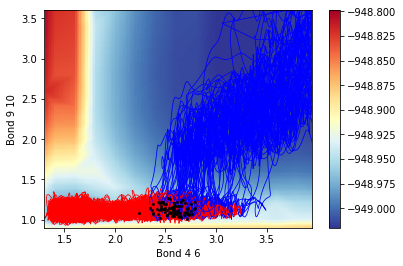

In [4]:
# Create energy 2D surface with all the trajectories

os.chdir(w_dir+'\Scans for 2D surface')

x =  df['Bond '+str(atom1)+' '+str(atom2)]
y =  df['Bond '+str(atom3)+' '+str(atom4)]
z =  df['E (u.a.)']

# convert to arrays to make use of previous answer to similar question
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
# print("x = ", x)
# print("y = ", y)
# print("z = ", z)

# Set up a regular grid of interpolation points
nInterp = 200
xi, yi = np.linspace(x.min(), x.max(), nInterp), np.linspace(y.min(), y.max(), nInterp)
xi, yi = np.meshgrid(xi, yi)

# Interpolate; there's also method='cubic' for 2-D data such as here
#rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
#zi = rbf(xi, yi)
zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='linear')

# To adjust the axis range, change the values in extent
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
       extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', cmap='RdYlBu_r')

plt.xlabel('Bond '+str(atom1)+' '+str(atom2))
plt.ylabel('Bond '+str(atom3)+' '+str(atom4))        
plt.colorbar()
# Define the directory containing the MD results

os.chdir(w_dir+'\MD results')

# Get the filenames from the command line prompt
files = []
for file in os.listdir():
    try:
        if file.split('.')[1] == 'csv':
            files.append(file)
    except:
        pass

# Set color scheme for the graph, either using only grey ('grey') 
# or using blue and red ('blue_red')
color_scheme = 'blue_red'

TS_starting_CN, TS_starting_CH = [],[]

for file in files:
    df_traj = pd.read_csv(file)
    starting_point,reverse_CN,reverse_CH, forw_CN, forw_CH = [],[],[],[],[]
    for i in range(len(df_traj['time'])):
        if df_traj['time'][i]==0.0:
            starting_point.append(df_traj['C-N'][i])
            starting_point.append(df_traj['C-H'][i])
            reverse_CN.append(df_traj['C-N'][i])
            reverse_CH.append(df_traj['C-H'][i])
            forw_CN.append(df_traj['C-N'][i])
            forw_CH.append(df_traj['C-H'][i])
            TS_starting_CN.append(df_traj['C-N'][i])
            TS_starting_CH.append(df_traj['C-H'][i])
        elif df_traj['time'][i] < 0.0:
            reverse_CN.append(df_traj['C-N'][i])
            reverse_CH.append(df_traj['C-H'][i])
        elif df_traj['time'][i] > 0.0:
            forw_CN.append(df_traj['C-N'][i])
            forw_CH.append(df_traj['C-H'][i])
    if color_scheme == 'grey':
        plt.plot(reverse_CN, reverse_CH, color='grey', linewidth=0.8) 
        plt.plot(forw_CN, forw_CH, color='grey', linewidth=0.8) 
    elif color_scheme == 'blue_red':
        plt.plot(reverse_CN, reverse_CH, color='b', linewidth=0.8) 
        plt.plot(forw_CN, forw_CH, color='r', linewidth=0.8) 
    plt.scatter(starting_point[0], starting_point[1],
             c='k', s=5, edgecolor='k', linewidths=0.6, zorder=15)
plt.ylim(0.9, 3.6)
plt.xlim(1.3, 3.95)
plt.show()

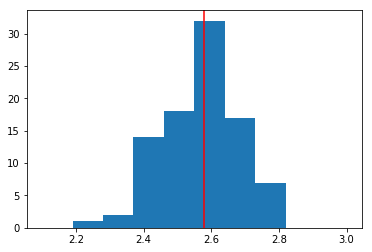

In [5]:
# Create a bin plot with the innitial coordinates of CN bonds

plt.hist(TS_starting_CN, bins=10, range=(2.1,3))
plt.axvline(2.58, color='r')

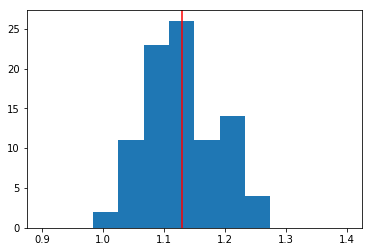

In [6]:
# Create a bin plot with the innitial coordinates of CH bonds

plt.hist(TS_starting_CH, bins=12, range=(0.9,1.4))
plt.axvline(1.13, color='r')

In [7]:
os.chdir(w_dir+'\\NBO results')

files_NBO = []
for file in os.listdir():
    try:
        if file.split('.')[1] == 'log' or file.split('.')[1] == 'out':
            files_NBO.append(file)
    except:
        pass
    
    
# Create the data (True) or retrieve the data from an Excel file (False)
new_NBO_data = False

# Define the atom numbers whose charges you want to sum up
NBO_atoms = [6,7,8]

if new_NBO_data == True:
    distance1,distance2 = [],[]
    Charge_NO2 = []
    
    for file in files_NBO:
    #Read molecule data from an input file
        infile = open(file,"r")
        readlines = infile.readlines()
        x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,Charge_NO2_indiv = [],[],[],[],[],[],[],[],[],[],[],[],[]
        for j in range(len(readlines)):
            if readlines[j].find("Input orientation") > -1:
                x1 = float(readlines[j+4+atom1].split()[3])
                y1 = float(readlines[j+4+atom1].split()[4])
                z1 = float(readlines[j+4+atom1].split()[5])
                x2 = float(readlines[j+4+atom2].split()[3])
                y2 = float(readlines[j+4+atom2].split()[4])
                z2 = float(readlines[j+4+atom2].split()[5])
                x3 = float(readlines[j+4+atom3].split()[3])
                y3 = float(readlines[j+4+atom3].split()[4])
                z3 = float(readlines[j+4+atom3].split()[5])
                x4 = float(readlines[j+4+atom4].split()[3])
                y4 = float(readlines[j+4+atom4].split()[4])
                z4 = float(readlines[j+4+atom4].split()[5])
                
            if readlines[j].find('Summary of Natural Population Analysis:') > -1:
                Charge_NO2_indiv = 0.0
                for atom in NBO_atoms:
                    Charge_NO2_indiv += float(readlines[j+5+atom].strip().split()[2])

        distance1.append(np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2))
        distance2.append(np.sqrt((x3-x4)**2 + (y3-y4)**2 + (z3-z4)**2))
        Charge_NO2.append(Charge_NO2_indiv)

    dict = {'Bond '+str(atom1)+' '+str(atom2): distance1, 'Bond '+str(atom3)+' '+str(atom4): distance2, 'Charge NO2': Charge_NO2} 
    df_NBO = pd.DataFrame(dict)

    export_excel = df_NBO.to_csv('2D_NBO_plot.csv', index = None, header=True)

elif new_data == False:
    df_NBO = pd.read_csv('2D_NBO_plot.csv')
print(df_NBO)

     Bond 4 6  Bond 9 10  Charge NO2
0    2.524465   1.199985    -0.66095
1    2.510910   1.401650    -0.58245
2    2.516818   1.533372    -0.56471
3    2.516544   1.799781    -0.54794
4    2.516302   1.934328    -0.55693
5    2.517549   2.133690    -0.53891
6    2.513116   2.395422    -0.51611
7    2.512438   2.515097    -0.54462
8    2.510631   2.799994    -0.54651
9    2.798750   1.198735    -0.64845
10   2.800498   1.313412    -0.61704
11   2.799193   1.599991    -0.55232
12   2.800000   1.799996    -0.54716
13   2.799985   1.997460    -0.54240
14   2.800060   2.208223    -0.54966
15   2.799980   2.400007    -0.52499
16   2.791971   2.500991    -0.53547
17   2.814545   2.700837    -0.52916
18   3.000264   1.193774    -0.66177
19   2.915875   1.340444    -0.57621
20   3.000000   1.581087    -0.53973
21   3.004519   1.799945    -0.53415
22   2.914207   1.994172    -0.53109
23   3.008613   2.205291    -0.51957
24   2.924321   2.400000    -0.54713
25   2.919712   2.599941    -0.54771
2

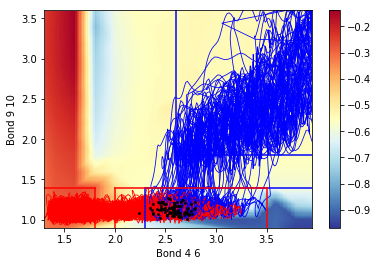

In [8]:
import scipy.interpolate
os.chdir(w_dir+'\\NBO results')

x =  df_NBO['Bond '+str(atom1)+' '+str(atom2)]
y =  df_NBO['Bond '+str(atom3)+' '+str(atom4)]
z =  df_NBO['Charge NO2']

# convert to arrays to make use of previous answer to similar question
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
# print("x = ", x)
# print("y = ", y)
# print("z = ", z)

# Set up a regular grid of interpolation points
nInterp = 200
xi, yi = np.linspace(x.min(), x.max(), nInterp), np.linspace(y.min(), y.max(), nInterp)
xi, yi = np.meshgrid(xi, yi)

# Interpolate; there's also method='cubic' for 2-D data such as here
#rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
#zi = rbf(xi, yi)
zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='linear')

# To adjust the axis range, change the values in extent
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
       extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', cmap='RdYlBu_r')

plt.xlabel('Bond '+str(atom1)+' '+str(atom2))
plt.ylabel('Bond '+str(atom3)+' '+str(atom4))        
plt.colorbar()
# Define the directory containing the MD results

os.chdir(w_dir+'\MD results')

# Get the filenames from the command line prompt
files = []
for file in os.listdir():
    try:
        if file.split('.')[1] == 'csv':
            files.append(file)
    except:
        pass

# Set color scheme for the graph, either using only grey ('grey') 
# or using blue and red ('blue_red')
color_scheme = 'blue_red'

TS_starting_CN, TS_starting_CH = [],[]

for file in files:
    df_traj = pd.read_csv(file)
    starting_point,reverse_CN,reverse_CH, forw_CN, forw_CH = [],[],[],[],[]
    for i in range(len(df_traj['time'])):
        if df_traj['time'][i]==0.0:
            starting_point.append(df_traj['C-N'][i])
            starting_point.append(df_traj['C-H'][i])
            reverse_CN.append(df_traj['C-N'][i])
            reverse_CH.append(df_traj['C-H'][i])
            forw_CN.append(df_traj['C-N'][i])
            forw_CH.append(df_traj['C-H'][i])
            TS_starting_CN.append(df_traj['C-N'][i])
            TS_starting_CH.append(df_traj['C-H'][i])
        elif df_traj['time'][i] < 0.0:
            reverse_CN.append(df_traj['C-N'][i])
            reverse_CH.append(df_traj['C-H'][i])
        elif df_traj['time'][i] > 0.0:
            forw_CN.append(df_traj['C-N'][i])
            forw_CH.append(df_traj['C-H'][i])
    if color_scheme == 'grey':
        plt.plot(reverse_CN, reverse_CH, color='grey', linewidth=0.8) 
        plt.plot(forw_CN, forw_CH, color='grey', linewidth=0.8) 
    elif color_scheme == 'blue_red':
        plt.plot(reverse_CN, reverse_CH, color='b', linewidth=0.8) 
        plt.plot(forw_CN, forw_CH, color='r', linewidth=0.8) 
    plt.scatter(starting_point[0], starting_point[1],
             c='k', s=5, edgecolor='k', linewidths=0.6, zorder=15)
plt.ylim(0.9, 3.6)
plt.xlim(1.3, 3.95)

# Add lines to delimit the different molecular spaces
# Variables for setting the lines
reagent_x_max = 1.8
reagent_y_max = 1.4
product_x_min = 2.6
product_y_min = 1.8
int1_x_min = 2
int1_x_max = 3.5
int1_y_max = 1.4
int2_x_min = 2.3
int2_y_max = 1.4
plt.plot([int2_x_min, 5], [int2_y_max, int2_y_max], 'b-')
plt.plot([int2_x_min, int2_x_min], [int2_y_max, 0], 'b-')
plt.plot([product_x_min, 5], [product_y_min,product_y_min], 'b-')
plt.plot([product_x_min, product_x_min], [product_y_min, 5], 'b-')
plt.plot([int1_x_max, int1_x_min], [int1_y_max, int1_y_max], 'r-')
plt.plot([int1_x_max, int1_x_max], [int1_y_max, 0], 'r-')
plt.plot([int1_x_min, int1_x_min], [int1_y_max, 0], 'r-')
plt.plot([reagent_x_max, 0], [reagent_y_max, reagent_y_max], 'r-')
plt.plot([reagent_x_max, reagent_x_max], [reagent_y_max, 0], 'r-')
plt.show()

In [10]:
# Analyze how long does it take to get to the starting material

os.chdir(w_dir+'\MD results')

# Get the filenames from the command line prompt
files = []
for file in os.listdir():
    try:
        if file.split('.')[1] == 'csv':
            files.append(file)
    except:
        pass

reagent_point,product_point,reaction_time,intermediate1_time,intermediate2_time,faraway_product = [],[],[],[],[],[]
filenames = []
for file in files:
    df_traj = pd.read_csv(file)
    stop_reagent = 0
    stop_product = 0
    reagent_point_indiv = 0
    product_point_indiv = 0
    intermediate1_time_indiv = 0
    intermediate2_time_indiv = 0
    reaction_time_indiv = 0
    faraway_product_indiv = 0
    for i in range(len(df_traj['time'])):
        if stop_reagent == 0:
            if df_traj['time'][i] > 0.0:
                if df_traj['C-N'][i] < reagent_x_max and df_traj['C-H'][i] < reagent_y_max: 
                    reagent_point_indiv = df_traj['time'][i]
                    stop_reagent = stop_reagent + 1
        if df_traj['time'][i] > 0.0:
            if df_traj['C-N'][i] > int1_x_min and df_traj['C-N'][i] < int1_x_max and df_traj['C-H'][i] < int1_y_max: 
                intermediate1_time_indiv = intermediate1_time_indiv + 1
        if df_traj['time'][i] < 0.0:
            if df_traj['C-N'][i] > int2_x_min and df_traj['C-H'][i] < int2_y_max: 
                intermediate2_time_indiv = intermediate2_time_indiv + 1
        if stop_product == 0:
            if df_traj['time'][i] < 0.0:
                if df_traj['C-N'][i] > product_x_min and df_traj['C-H'][i] > product_y_min: 
                    product_point_indiv = -df_traj['time'][i]
                    faraway_product_indiv = df_traj['C-N'][i]
    reagent_point.append(reagent_point_indiv)
    product_point.append(product_point_indiv)
    intermediate1_time.append(intermediate1_time_indiv)
    intermediate2_time.append(intermediate2_time_indiv)
    faraway_product.append(faraway_product_indiv)
    
    if reagent_point_indiv != 0 and product_point_indiv != 0:
        reaction_time.append(reagent_point_indiv+product_point_indiv)
    else:
        print('File '+file+' did not finish in the reagent or product.')
    filenames.append(file)


File E2_vs_E1_0001-K.csv did not finish in the reagent or product.


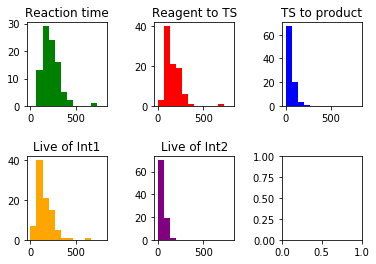

In [11]:
# Create a bin plot with the time required from the starting reagent to the product
divided_time = []
divided_time.append(reagent_point)
divided_time.append(product_point)

fig, axes = plt.subplots(nrows=2, ncols=3)
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.hist(reaction_time, bins=12, range=(0,800), color='green')
ax0.set_title('Reaction time')
ax1.hist(reagent_point, bins=12, range=(0,800), color='red')
ax1.set_title('Reagent to TS')
ax2.hist(product_point, bins=12, range=(0,800), color='blue')
ax2.set_title('TS to product')
ax3.hist(intermediate1_time, bins=12, range=(0,800), color='orange')
ax3.set_title('Live of Int1')
ax4.hist(intermediate2_time, bins=12, range=(0,800), color='purple')
ax4.set_title('Live of Int2')

plt.subplots_adjust(wspace = 0.6, hspace = 0.6)
    
plt.show()

# calculate average time for the 3 plots and include 3 lines
# plt.axvline(1.13, color='r')

The slowest trajectory from reagent to product is E2_vs_E1_0010_7sample.csv
The fastest trajectory from reagent to product is E2_vs_E1_0001-H.csv
The trajectory with longest C-N before H abstraction is E2_vs_E1_0002_9sample.csv


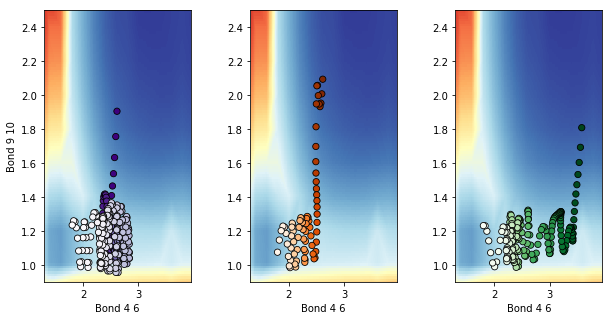

In [12]:
# Create energy 2D surface with the longest and shortest trajectory

os.chdir(w_dir+'\Scans for 2D surface')

x =  df['Bond '+str(atom1)+' '+str(atom2)]
y =  df['Bond '+str(atom3)+' '+str(atom4)]
z =  df['E (u.a.)']

# convert to arrays to make use of previous answer to similar question
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
# print("x = ", x)
# print("y = ", y)
# print("z = ", z)

# Set up a regular grid of interpolation points
nInterp = 200
xi, yi = np.linspace(x.min(), x.max(), nInterp), np.linspace(y.min(), y.max(), nInterp)
xi, yi = np.meshgrid(xi, yi)

# Interpolate; there's also method='cubic' for 2-D data such as here
#rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
#zi = rbf(xi, yi)
zi = scipy.interpolate.griddata((x, y), z, (xi, yi), method='linear')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax0, ax1, ax2 = axes.flatten()

# To adjust the axis range, change the values in extent
ax0.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
       extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', cmap='RdYlBu_r')
ax1.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
       extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', cmap='RdYlBu_r')
ax2.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
       extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto', cmap='RdYlBu_r')

ax0.set_xlabel('Bond '+str(atom1)+' '+str(atom2))
ax0.set_ylabel('Bond '+str(atom3)+' '+str(atom4))        
ax1.set_xlabel('Bond '+str(atom1)+' '+str(atom2))
# ax1.set_ylabel('Bond '+str(atom3)+' '+str(atom4))  
ax2.set_xlabel('Bond '+str(atom1)+' '+str(atom2))
# ax2.set_ylabel('Bond '+str(atom3)+' '+str(atom4))  

# Define the directory containing the MD results

os.chdir(w_dir+'\MD results')

# Get the filenames from the command line prompt
files = []
for file in os.listdir():
    try:
        if file.split('.')[1] == 'csv':
            files.append(file)
    except:
        pass
ymax=2.5
ax0.set_ylim(0.9, ymax)
ax0.set_xlim(1.3, 3.95)
ax1.set_ylim(0.9, ymax)
ax1.set_xlim(1.3, 3.95)
ax2.set_ylim(0.9, ymax)
ax2.set_xlim(1.3, 3.95)

# Detect the longest and shortest trajectories
file_max = ''
file_min = ''
file_faraway = ''

for i in range(len(reaction_time)):
    if reaction_time[i] == max(reaction_time):
        file_max = filenames[i]
    elif reaction_time[i] == min(reaction_time):
        file_min = filenames[i]
    if faraway_product[i] == max(faraway_product):
        file_faraway = filenames[i]
        
df_max = pd.read_csv(file_max)
df_min = pd.read_csv(file_min)
df_faraway = pd.read_csv(file_faraway)

print('The slowest trajectory from reagent to product is '+file_max)
print('The fastest trajectory from reagent to product is '+file_min)
print('The trajectory with longest C-N before H abstraction is '+file_faraway)

# Detects the points in the limits of the reagent and product regions
start_longest,start_max = 0,0
stop_longest,stop_max = 0,0
start_shortest,start_min = 0,0
stop_shortest,stop_min = 0,0
start_faraway,start_away = 0,0
stop_faraway,stop_away = 0,0

# This part looks for the values where the reaction leaves the reagent zone and where the
# reaction enters the product zone
for i in range(len(filenames)):
    if filenames[i] == file_max:
        start_longest = reagent_point[i]
        stop_longest = -product_point[i]
    elif filenames[i] == file_min:
        start_shortest = reagent_point[i]
        stop_shortest = -product_point[i]
    if filenames[i] == file_faraway:
        start_faraway = reagent_point[i]
        stop_faraway = -product_point[i]        
        
# This part recognizes which indexes of the dataframe correspond to the values located above
for i in range(len(df_max["time"])):
    if df_max["time"][i] == start_longest:
        stop_max = i
    elif df_max["time"][i] == stop_longest:  
        start_max = i
for i in range(len(df_min["time"])):
    if df_min["time"][i] == start_shortest:
        stop_min = i
    elif df_min["time"][i] == stop_shortest:  
        start_min = i
for i in range(len(df_faraway["time"])):
    if df_faraway["time"][i] == start_faraway:
        stop_away = i
    elif df_faraway["time"][i] == stop_faraway:  
        start_away = i
        
ax0.scatter(df_max['C-N'][start_max:stop_max], df_max['C-H'][start_max:stop_max],
             c=df_max["time"][start_max:stop_max], s=40, cmap="Purples_r",
             edgecolor='k', linewidths=0.8)
ax1.scatter(df_min['C-N'][start_min:stop_min], df_min['C-H'][start_min:stop_min],
             c=df_min["time"][start_min:stop_min], s=40, cmap="Oranges_r",
             edgecolor='k', linewidths=0.8)
ax2.scatter(df_faraway['C-N'][start_away:stop_away], df_faraway['C-H'][start_away:stop_away],
             c=df_faraway["time"][start_away:stop_away], s=40, cmap="Greens_r",
             edgecolor='k', linewidths=0.8)

plt.subplots_adjust(wspace = 0.4)

plt.show()